# Etude des données des subreddits sur l'activité des Etats-Unis 

# 

Ce projet a pour but d'étudier le lien entre tendance des subreddits et l'économie des Etats-Unis à partir de 2017. Nous étudierons l'effet de la quantité des votes pour le post Reddit anti-work puis le degré moyen de positivité des subreddits principaux en fonction du temps. Nous regarderons les données de PIB, d'inflation, et d'indice des prix à la consommation.

Il faut au préalable avoir télécharger les bibliothèques suivantes :

copy, datetime, io, matplotlib, nltk, numpy, os, pandas, re, requests, torch, psaw, random, sklearn, time, tqdm, transformers, zipfile

In [1]:
import copy
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import time
import torch
import torch.nn as nn

from datetime import datetime
from psaw import PushshiftAPI
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from train_bert import bert_predict,BertClassifier,text_preprocessing,tokenizer,preprocessing_for_bert,MAX_LEN,device
from transformers import BertModel

No GPU available, using the CPU instead.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## I - Importation des données de Reddit

On va utiliser l'api psaw pour effectuer du scrapping sur Reddit pour récupérer les données des posts antiwork depuis 2018 (données inexistantes avant) puis les données des posts principaux depuis 2018.

In [2]:
api = PushshiftAPI()

In [3]:
def scraping_reddit_antiwork():
    start_epoch = int(datetime(2018, 1, 1).timestamp())
    end_epoch = int(datetime(2021, 12, 31).timestamp())
    api_request_generator = api.search_submissions(
        after=start_epoch,
        before=end_epoch,
        subreddit='antiwork',
        limit=4000,
        score=">40"
    )
    df = pd.DataFrame([submission.d_ for submission in api_request_generator])
    df["created_utc"] = df["created_utc"].apply(datetime.fromtimestamp)
    df = df[['score','created_utc']]
    df = df.rename(columns={'created_utc':'date'})
    return df

In [4]:
df = scraping_reddit_antiwork()

C:\Users\nicol\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)


In [5]:
df.head()

,score,date
0,57,2021-12-09 07:08:38
1,45,2021-12-09 06:26:55
2,81,2021-12-09 06:22:33
3,68,2021-12-09 06:21:43
4,43,2021-12-09 06:20:32


On obtient un dataframe présentant la quantité de votes pour chaque subreddit ainsi que la date à laquelle il a été
posté.

Ensuite, on va générer les données des subsreddit ayant recueillis le plus de votes depuis 2018.

In [6]:
def scraping_reddit_top_subs():
    start_epoch=int(datetime(2018, 1, 1).timestamp())
    end_epoch=int(datetime(2021, 12, 31).timestamp())
    api_request_generator = api.search_comments(
        after=start_epoch,
        before = end_epoch,
        limit=4000,
        score = ">30000"
    )
    df = pd.DataFrame([submission.d_ for submission in api_request_generator])
    df["created_utc"] = df["created_utc"].apply(datetime.fromtimestamp)
    df = df[['created_utc','body','score']]
    return df

In [7]:
df_feel = scraping_reddit_top_subs()

C:\Users\nicol\anaconda3\lib\site-packages\psaw\PushshiftAPI.py:252: UserWarning: Not all PushShift shards are active. Query results may be incomplete
  warnings.warn(shards_down_message)


## II - Importation des données économiques des Etats-Unis

On utilisera les données de la banque de la réserve fédérale américaine.

### a) Données de PIB

In [8]:
def dowload_PIB_growth():
    # importe les données de PIB des Etats-Unis en dataframe
    url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor\
    =%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=y\
    es&show_axis_titles=yes&show_tooltip=yes&id=GDP&scale=left&cosd=2017-10-01&coed=2021-07-01&line_color=%234572a7&link_values\
    =false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly&fam=avg&fgst=lin&fgsnd=2020-\
    02-01&line_index=1&transformation=lin&vintage_date=2022-01-02&revision_date=2022-01-02&nd=1947-01-01'
    
    GDP = requests.get(url,allow_redirects=True).content.decode("utf-8")
    gdp = [float(GDP[20+i*21:29+i*21]) for i in range(16)] + [round(1.022*float(GDP[20+15*21:29+15*21]),3)] 
    date_df = pd.date_range('2017-10-01', periods=17, freq='3M')
    gdp_df = pd.DataFrame({ 'date': date_df,'GDP': gdp})
    
    def _31_to_01(t):
        T = str(t)
        return T[:8]+"01"
    
    gdp_df['date'] = gdp_df['date'].apply(_31_to_01) 
    gdp_df = gdp_df.set_index('date')
    gdp_growth = gdp_df.pct_change()[1:]
    gdp_growth = gdp_growth.reset_index()
    return gdp_growth

In [9]:
gdp_growth = dowload_PIB_growth()

<AxesSubplot:title={'center':'Taux de croissance du PIB aux Etats-Unis entre 2018 et 2021 en milliards de dollars'}, xlabel='date'>

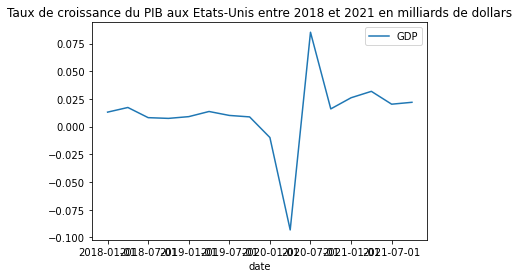

In [10]:
gdp_growth.plot(kind='line',x='date',y='GDP',title='Taux de croissance du PIB aux Etats-Unis entre 2018 et 2021 en milliards \
de dollars')

### b) Données de l'inflation

In [11]:
def download_inflation():
    url2 = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcol\
    or=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legen\
    d=yes&show_axis_titles=yes&show_tooltip=yes&id=T10YIE&scale=left&cosd=2018-01-01&coed=2021-12-31&line_color=%234572a7&link\
    _values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily&fam=avg&fgst=lin&fgsnd=2\
    020-02-01&line_index=1&transformation=lin&vintage_date=2022-01-04&revision_date=2022-01-04&nd=2003-01-02"
    inflation = requests.get(url2,allow_redirects=True).content.decode("utf-8")
    data = io.StringIO(inflation)
    df_inflation = pd.read_csv(data, sep=",")
    df_inflation['T10YIE'] = pd.to_numeric(df_inflation['T10YIE'],errors='coerce')
    return df_inflation

In [12]:
df_inflation = download_inflation()

<AxesSubplot:title={'center':"Taux d'inflation aux Etats-Unis entre 2018 et 2021"}, xlabel='DATE'>

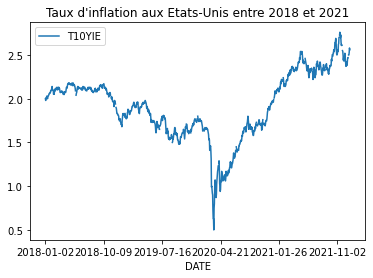

In [13]:
df_inflation.plot(kind='line',x='DATE',y="T10YIE",title="Taux d'inflation aux Etats-Unis entre 2018 et 2021")

### c) Données de CPI (indice des prix à la consommation)

In [14]:
def download_CPI():
    url3 = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcol\
    or=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legen\
    d=yes&show_axis_titles=yes&show_tooltip=yes&id=CPILFESL&scale=left&cosd=2018-01-01&coed=2021-11-01&line_color=%234572a7&li\
    nk_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgs\
    nd=2020-02-01&line_index=1&transformation=lin&vintage_date=2022-01-04&revision_date=2022-01-04&nd=1957-01-01"
    CPI = requests.get(url3,allow_redirects=True).content.decode("utf-8")
    data = io.StringIO(CPI)
    df_CPI = pd.read_csv(data, sep=",")
    df_CPI['CPILFESL'] = pd.to_numeric(df_CPI['CPILFESL'],errors='coerce')
    return df_CPI

In [15]:
df_CPI = download_CPI()

<AxesSubplot:title={'center':'CPI aux Etats-Unis entre 2018 et 2021'}, xlabel='DATE'>

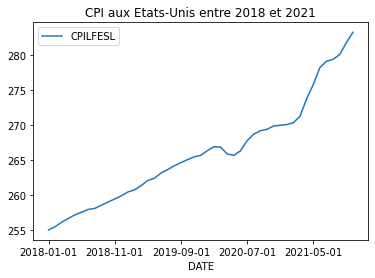

In [16]:
df_CPI.plot(kind='line',x='DATE',y="CPILFESL",title="CPI aux Etats-Unis entre 2018 et 2021")

## III - Visualisation des données de Reddit sur le thème Antiwork entre 2017 et 2021

Pour visualiser les votes des posts Reddit, on va devoir utiliser un nuage de points avec pour abscisse la date et en ordonnée la quantité de votes. Comme ce post a connu un accroissement de popularité au fil des années, l'échelle logarithmique est à utiliser pour mieux voir l'évolution.

<AxesSubplot:title={'center':'Score des posts reddit sur le thème antiwork entre 2018 et 2021'}, xlabel='date', ylabel='score'>

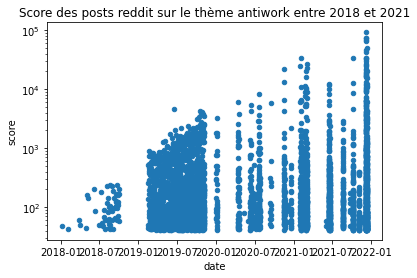

In [17]:
df.plot(kind='scatter',x='date',y='score',logy=True,title='Score des posts reddit sur le thème antiwork entre 2018 et 2021')

Ensuite, on va rendre les variables moins abrutes en créant une variable continue qui à une date donnée associe le score moyen des posts reddit sur une période fixe.

## IV - Comparaison entre le taux de croissance du PIB aux Etats-Unis et la tendance du post anti-work

On commence par calculer la moyenne de la tendance du post anti-work trimestrielle car le pib est donné chaque trimestre. 

In [18]:
def antiwork_quarter(df):
    df_quarter = copy.deepcopy(df)

    def to_quarter(t):
        T = str(t)
        if int(T[5:7]) < 4:
            return pd.Timestamp(T[:5]+"01")
        elif int(T[5:7]) < 7:
            return pd.Timestamp(T[:5]+"04")
        elif int(T[5:7]) < 10:
            return pd.Timestamp(T[:5]+"07")
        else:
            return pd.Timestamp(T[:5]+"10")
    
    df_quarter['date'] = df_quarter['date'].apply(to_quarter) 
    df_quarter = df_quarter.groupby(by='date').sum().groupby(level=[0]).cumsum()
    df_quarter = df_quarter.reset_index()
    return df_quarter

In [19]:
df_quarter = antiwork_quarter(df)

Pour avoir des données comparables en terme de taille, on centre puis on réduit les variables.

In [20]:
gdp_np = gdp_growth['GDP'].to_numpy()
score_np = df_quarter['score'].to_numpy()

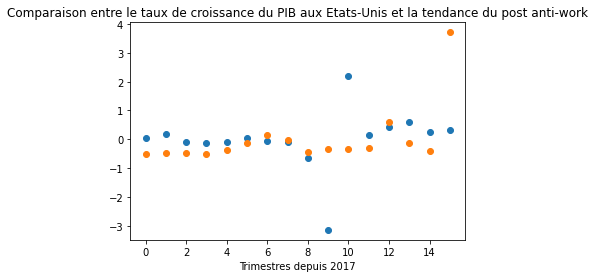

In [21]:
plt.scatter(range(16),(gdp_np - np.mean(gdp_np))/np.std(gdp_np).reshape((-1, 1)))
plt.scatter(range(16),(score_np - np.mean(score_np))/np.std(score_np))
plt.xlabel("Trimestres depuis 2017")
plt.title("Comparaison entre le taux de croissance du PIB aux Etats-Unis et la tendance du post anti-work")
plt.show()

Ces deux séries temporelles peuvent sembler avoir une tendande proche mais malheuresement il n'est pas possible d'en tirer des conclusions claires comme une corrélation entre deux séries temporelles.

## V - Comparaison entre les indices des prix à la consommation aux Etats-Unis et la tendance du post anti-work

In [22]:
def to_month(t):
    T=str(t)
    return T[:8]

def antiwork_month(df):
    df_month = copy.deepcopy(df)    
    df_month['date'] = df_month['date'].apply(to_month) 
    df_month = df_month.groupby(by='date').sum().groupby(level=[0]).mean()
    df_month = df_month.reset_index()
    
    scorem_np = df_month['score'].to_numpy()
    scorem_np = (scorem_np - np.mean(scorem_np))/np.std(scorem_np)
    df_month["scorem_np"] = scorem_np
    return df_month
    
def CPI_month(df_CPI):
    df_CPI['DATE'] = df_CPI['DATE'].apply(to_month) 
    df_CPI = df_CPI.groupby(by='DATE').sum().groupby(level=[0]).mean()
    df_CPI = df_CPI.reset_index()
    
    cpi_np = df_CPI['CPILFESL'].to_numpy()
    cpi_np = (cpi_np - np.mean(cpi_np))/np.std(cpi_np)
    cpi_np = cpi_np.reshape((-1, 1))
    df_CPI["cpi_np"] = cpi_np
    return df_CPI

In [23]:
df_month = antiwork_month(df)
df_CPI = CPI_month(df_CPI)

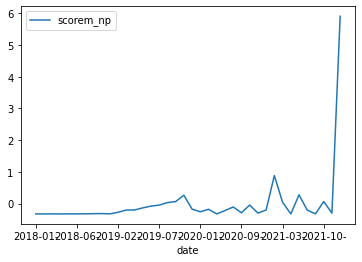

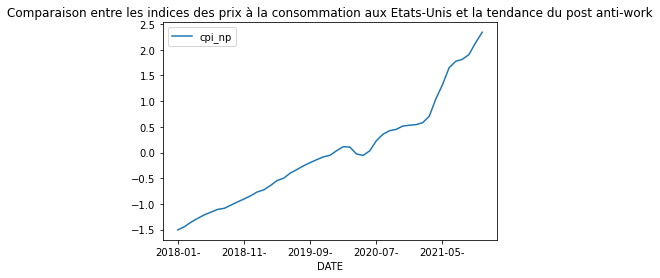

In [24]:
df_month.plot(kind='line',x='date',y='scorem_np')
df_CPI.plot(kind='line',x='DATE',y='cpi_np')
plt.title("Comparaison entre les indices des prix à la consommation aux Etats-Unis et la tendance du post anti-work")
plt.show()

Comme pour la comparaison avec le taux de PIB, il est difficile d'effectuer un calcul de corrélation.

 ## VI - Analyse des sentiments des principales tendances Reddit en 2021

Dans cette partie, on va utiliser un réseau de neurones préentrainé pour indiquer si le titre du post Reddit est positif ou non.

Pour cela, nous avons entrainé le réseau de neurones Bert. A l'aide de données de tweets, ce modèle a pu apprendre à indiquer si une phrase est négative ou non. L'algorithme d'entrainement est disponible sur le notebook train_bert.ipynb. Ce réseau de neurones a été préentrainé à l'aide d'un tutoriel en ligne. Durant l'entrainement, ce réseau de neurones a eu une efficacité de 90%.

La valeur 0 indique que la phrase est négative et la valeur 1 indique que la phrase ne l'est pas.

Nous importons le réseau de neurones entrainé depuis SSP CLoud.

In [25]:
def get_bert():
    url_bert =  "https://minio.lab.sspcloud.fr/ntollot/Ressources projet informatique/bert_model.pt"
    url_data = requests.get(url_bert,allow_redirects=True).content
    url_data = io.BytesIO(url_data)
    bert_classifier = BertClassifier()
    bert_classifier.load_state_dict(torch.load(url_data))
    bert_classifier.eval()
    return bert_classifier

In [26]:
bert_classifier = get_bert()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


On va rajouter aux meilleurs subreddits le sentiment qui y dégage.

In [27]:
def generate_feelings(df):
    # Rajoute au dataframe le sentiment supposé
    test_inputs, test_masks = preprocessing_for_bert(df.body)
    test_dataset = TensorDataset(test_inputs, test_masks)
    test_sampler = SequentialSampler(test_dataset)
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)
    probs = bert_predict(bert_classifier, test_dataloader)
    feeling = np.argmax(probs,axis=1)
    df["feeling"] = feeling
    df = df.loc[df_feel['body']!="[removed]"] # on enlève les posts ayant pour titre [deleted]
    df = df.reset_index()
    return df

In [28]:
df_feel = generate_feelings(df_feel)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\nicol\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2226: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


On va lisser la variable en prennant les moyennes mensuelles.

In [29]:
def feelings_month(df):
    # moyenne les données par mois
    df_feeling = copy.deepcopy(df)
    def min_to_day(t):
        T = str(t)
        return pd.Timestamp(T[:7])
    df_feeling['created_utc'] = df_feeling['created_utc'].apply(min_to_day)
    df_feeling = df_feeling.groupby(by='created_utc').mean().groupby(level=[0]).cumsum()
    df_feeling = df_feeling.reset_index()
    return df_feeling

In [30]:
df_feeling = feelings_month(df_feel)

<AxesSubplot:title={'center':'Appréciation des posts reddit'}, xlabel='date'>

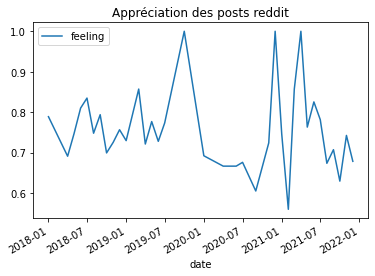

In [31]:
df_feeling.plot(kind='line',x='created_utc',y='feeling',xlabel='date',title='Appréciation des posts reddit')

<AxesSubplot:title={'center':'Taux de croissance du PIB aux Etats-Unis entre 2018 et 2021 en milliards de dollars'}, xlabel='date'>

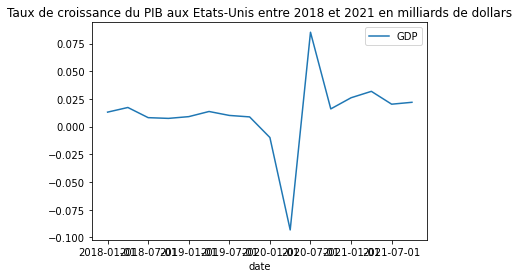

In [32]:
gdp_growth.plot(kind='line',x='date',y='GDP',title='Taux de croissance du PIB aux Etats-Unis entre 2018 et 2021 en milliards \
de dollars')

On peut aperçevoir une hausse importante des sentiments négatifs lors de la première et de la deuxième vague de Covid aux Etats-Unis, qui se sont traduites par une baisse de PIB. Cette tendance semble se confirmer en ajoutant des données supplémentaires.